## Notebook to compare the different explainability methods for Transynergy
Here we first show the 4 methods overall and then by cell line, but don't go in depth about the biological notions, since we do that in the individual notebooks. Lastly, we show the correlation between the methods using 3 ways, but we focus on Spearman rank.

In [1]:
import sys
from pathlib import Path
import os 

project_root = Path.cwd().parents[1]  
sys.path.append(str(project_root))
os.chdir(project_root)

In [2]:
from explainability.explaination_config import ExplainationConfig
config = ExplainationConfig(
    paper="transynergy",
)
feature_names = config.feature_names

In [3]:
from explainability.shapley.utils import load_shap_data
from explainability.am.load_results import load_am_results_by_cell_line
import numpy as np
import torch

shap_values, inputs, feature_names, shap_indices = load_shap_data("transynergy")
print(shap_values.shape)

SAVE_PATH = "explainability/ig/results/transynergy_integrated_gradients_shuffled.pt"
all_attributions = torch.load(SAVE_PATH, weights_only=False)
ig_values = all_attributions.squeeze(axis=1) 
ig_values = ig_values.detach().cpu().numpy()
ig_values = ig_values.reshape(ig_values.shape[0], -1)
print(ig_values.shape)

lrp_values = np.load("explainability/lrp/results/transynergy_subsample_False/relevances.npy")
lrp_values = lrp_values.reshape(lrp_values.shape[0], -1)
print(lrp_values.shape)

am_prototype = load_am_results_by_cell_line(paper ="transynergy", cell_line="prototypeAM", regularization="l2_input")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


(1803, 7206)
(22300, 7206)
(7708, 7206)


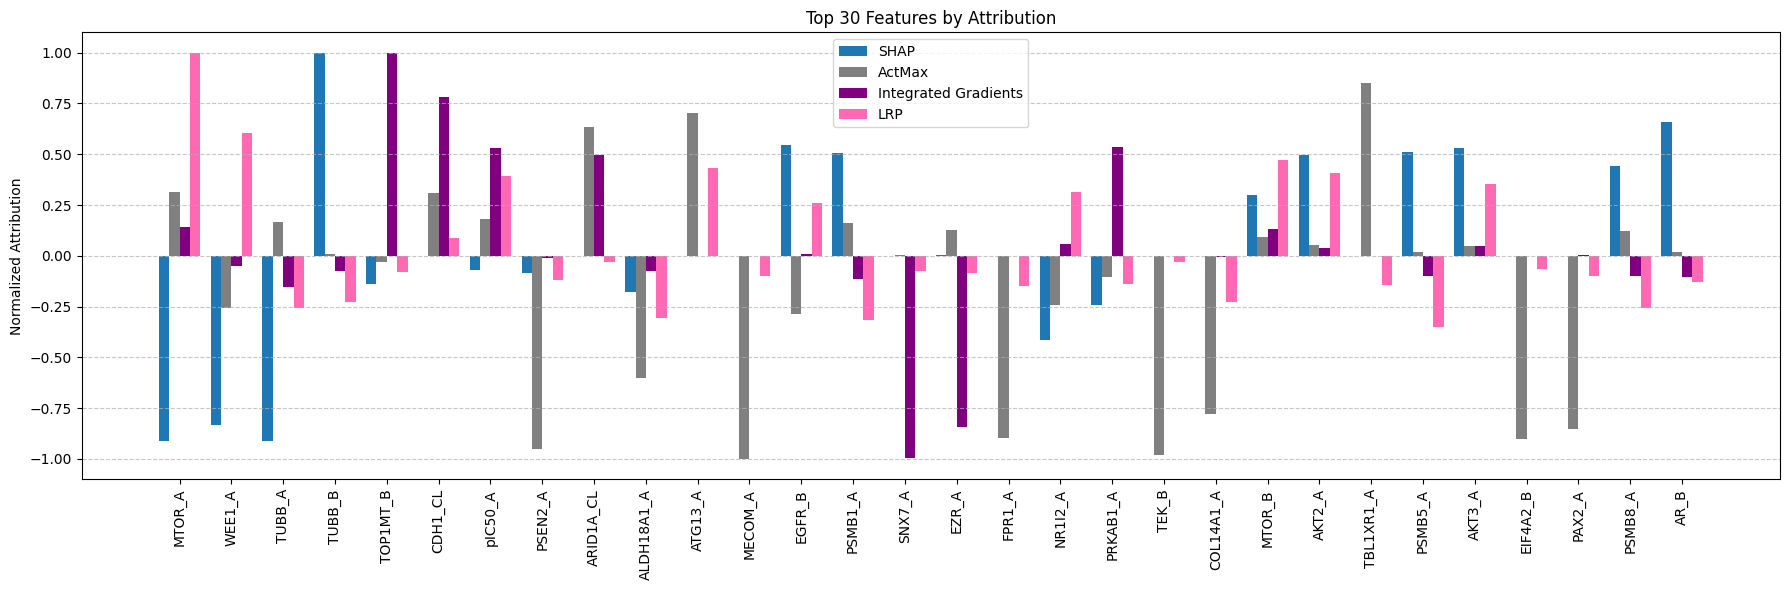

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_and_rescale(arr):
    mean_vals = np.mean(arr, axis=0)
    normed = mean_vals / np.sum(np.abs(mean_vals))
    return normed / np.max(np.abs(normed))

# Normalize each method
shap_norm = normalize_and_rescale(shap_values)
ig_norm = normalize_and_rescale(ig_values)
lrp_norm = normalize_and_rescale(lrp_values)

am_norm = am_prototype / np.sum(np.abs(am_prototype))
am_norm = am_norm / np.max(np.abs(am_norm))

# Mean importance to select top-k features
mean_importance = (
    np.abs(shap_norm) + np.abs(ig_norm) + np.abs(lrp_norm) + np.abs(am_norm)
) / 4.0
top_k = 30
top_indices = np.argsort(mean_importance)[-top_k:][::-1]

# Extract top-k values
x = np.arange(top_k)
shap_top = shap_norm[top_indices]
am_top = am_norm[top_indices]
ig_top = ig_norm[top_indices]
lrp_top = lrp_norm[top_indices]
feature_names_top = [feature_names[i] for i in top_indices]

# Plot settings
width = 0.2
methods = ['SHAP', 'ActMax', 'Integrated Gradients', 'LRP']
colors = ['#1f77b4', 'gray', 'purple', 'hotpink']

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(x - 1.5*width, shap_top, width, label='SHAP', color=colors[0])
ax.bar(x - 0.5*width, am_top, width, label='ActMax', color=colors[1])
ax.bar(x + 0.5*width, ig_top, width, label='Integrated Gradients', color=colors[2])
ax.bar(x + 1.5*width, lrp_top, width, label='LRP', color=colors[3])

ax.set_ylabel('Normalized Attribution')
ax.set_title(f'Top {top_k} Features by Attribution')
ax.set_xticks(x)
ax.set_xticklabels(feature_names_top, rotation=90)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552


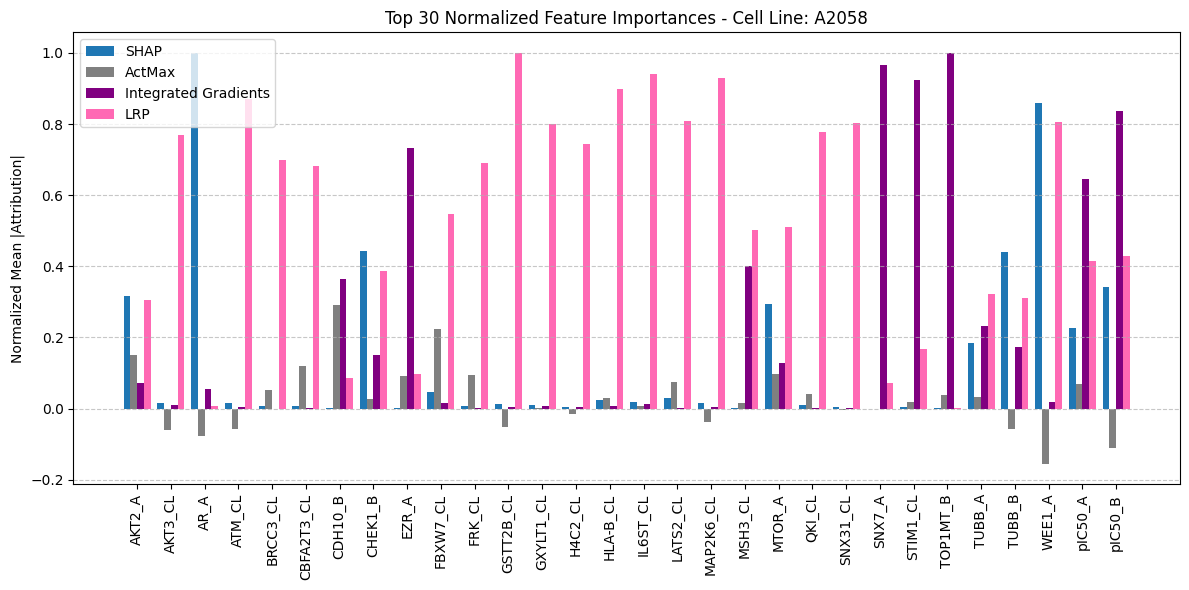

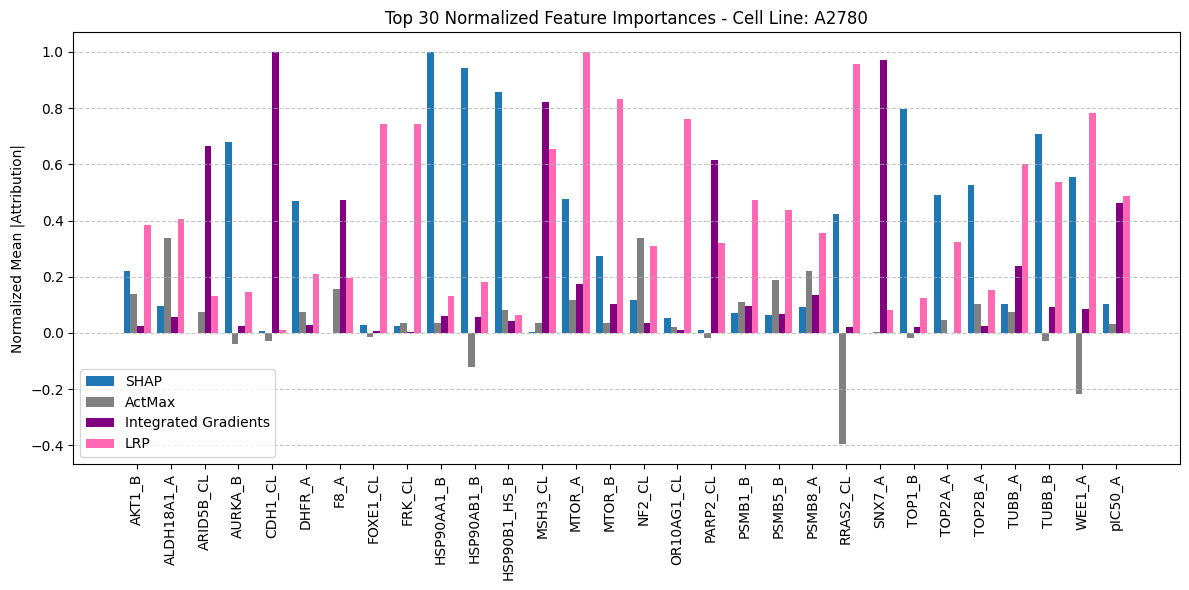

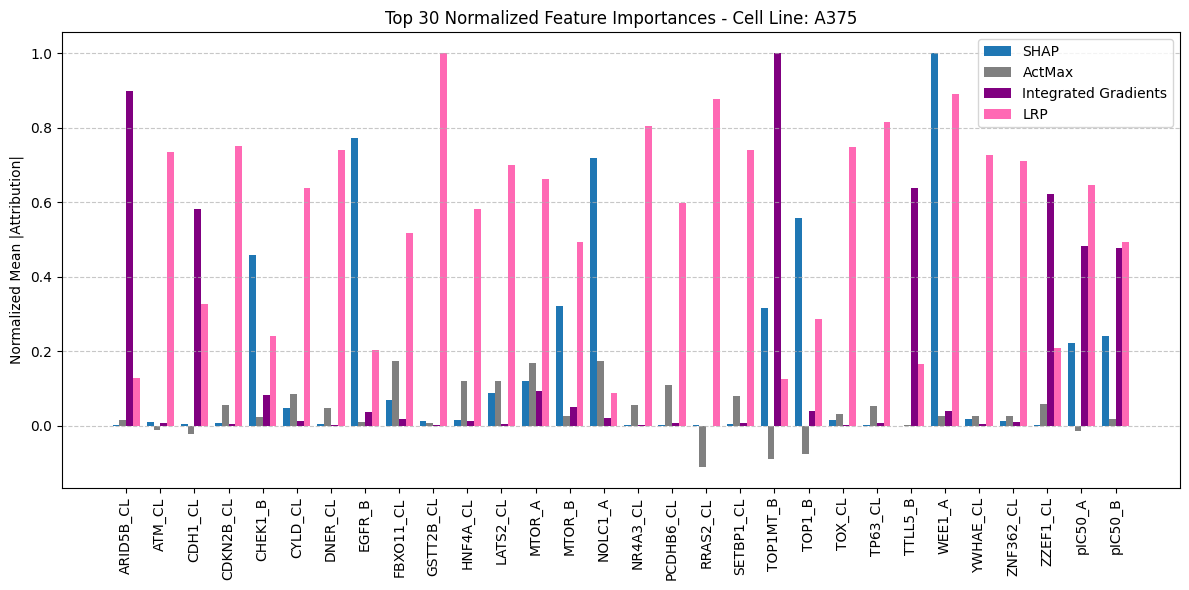

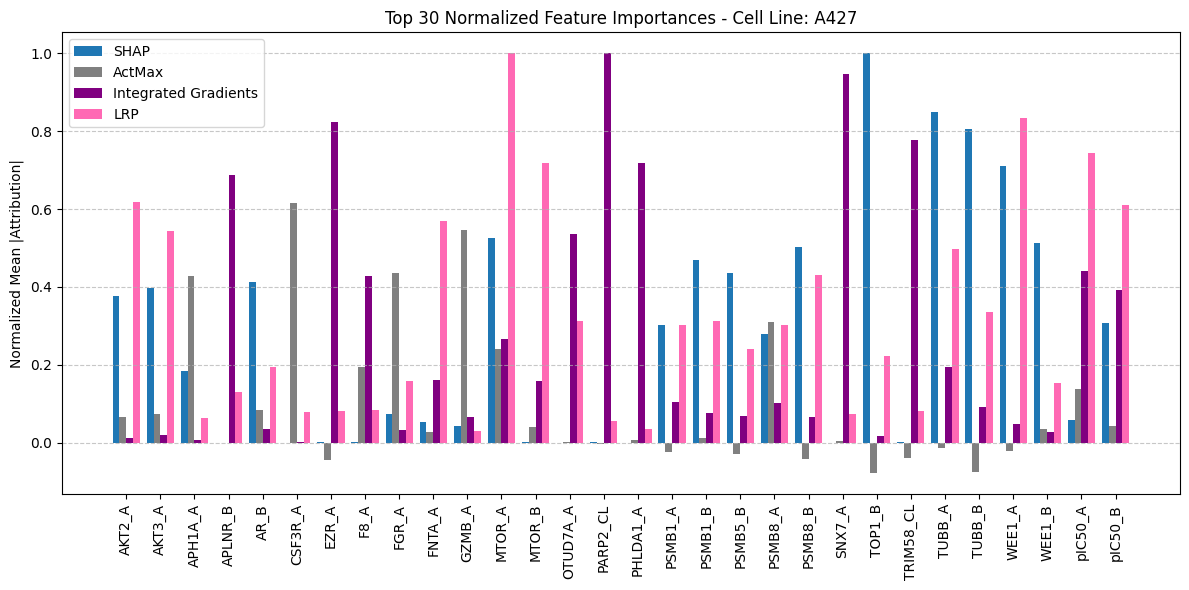

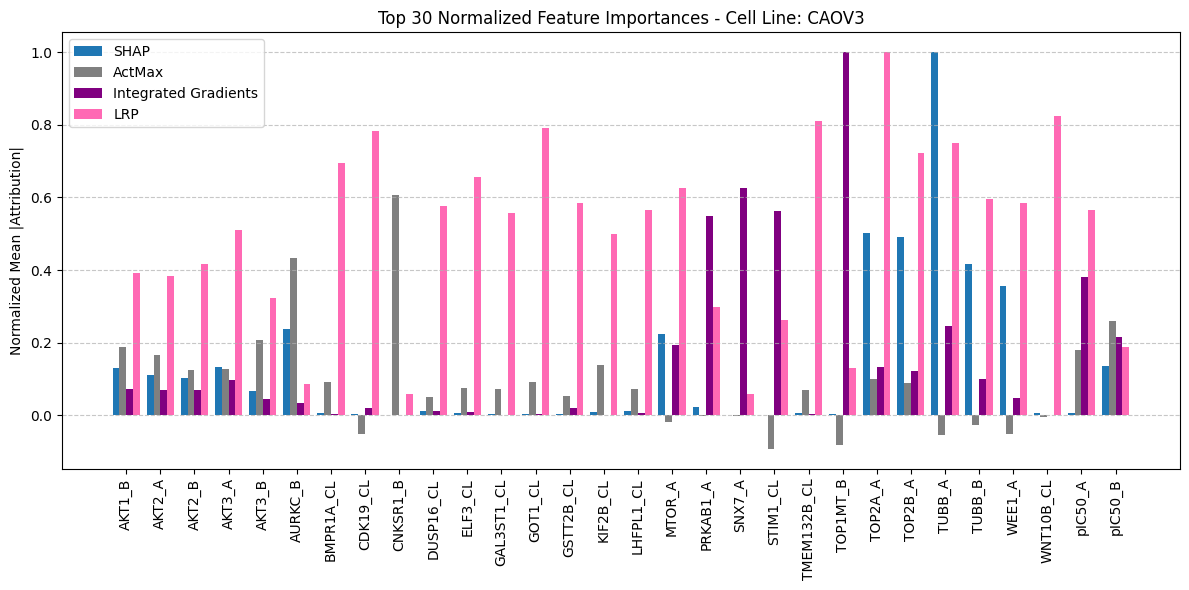

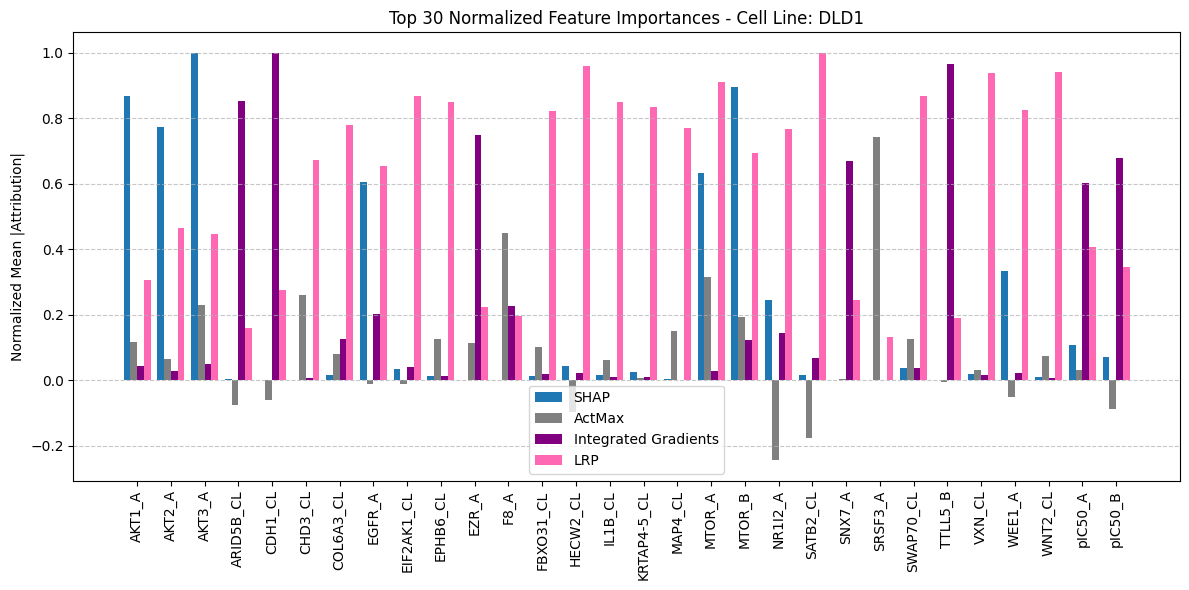

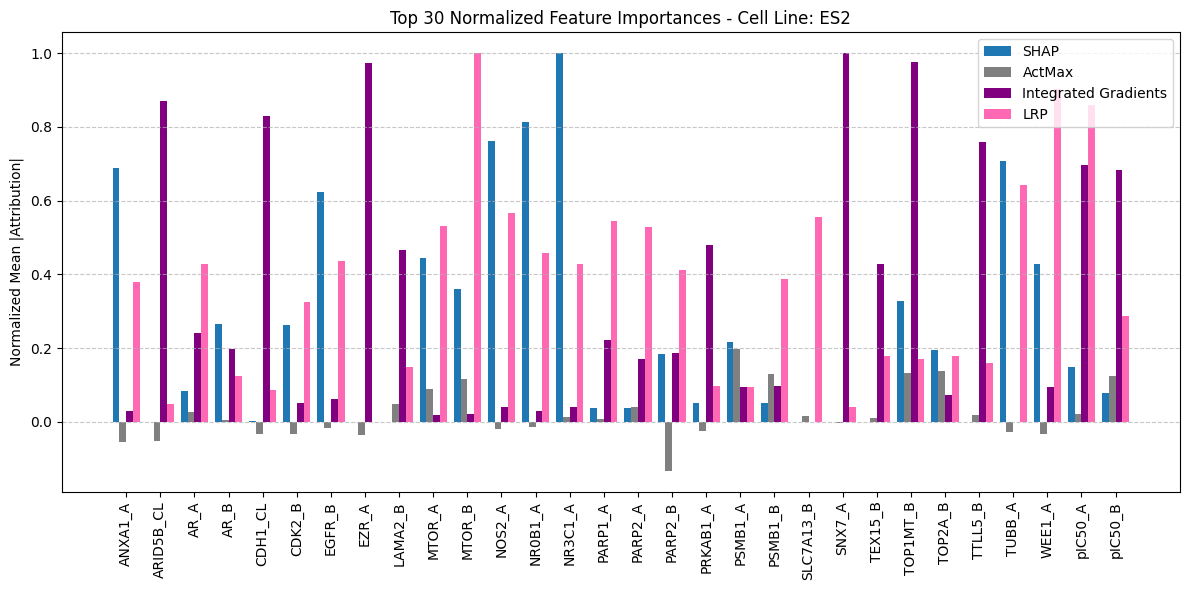

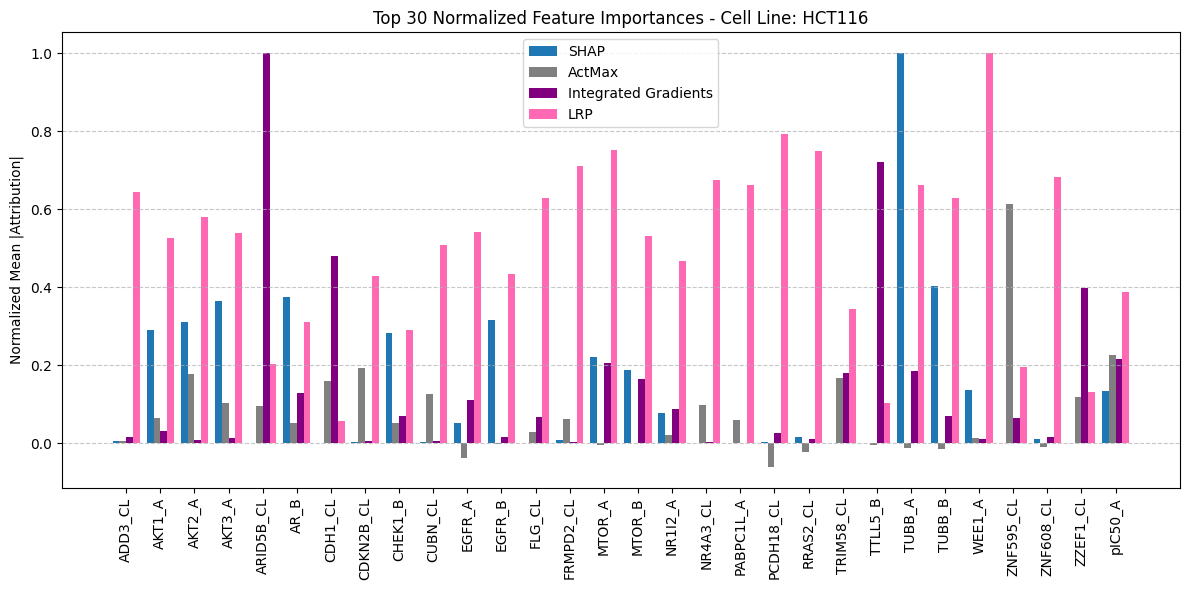

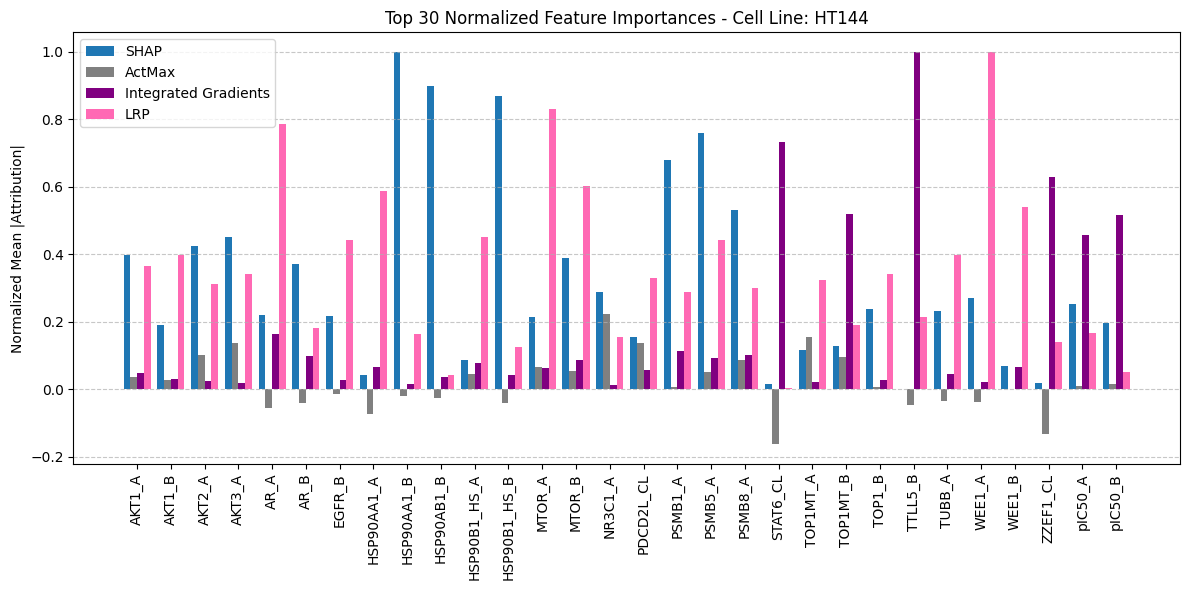

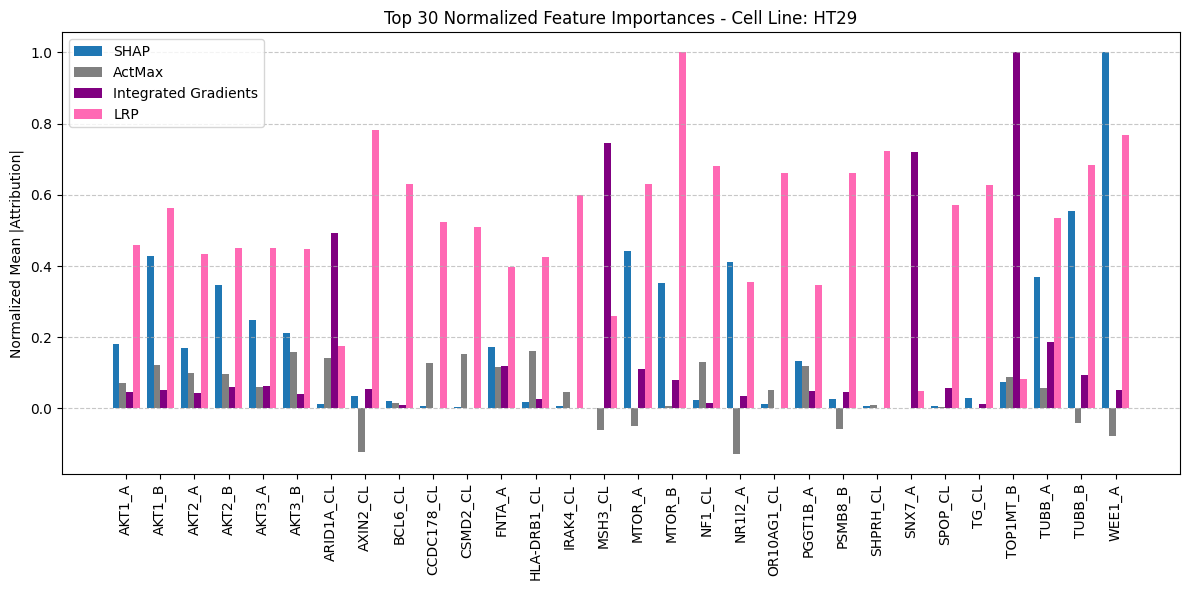

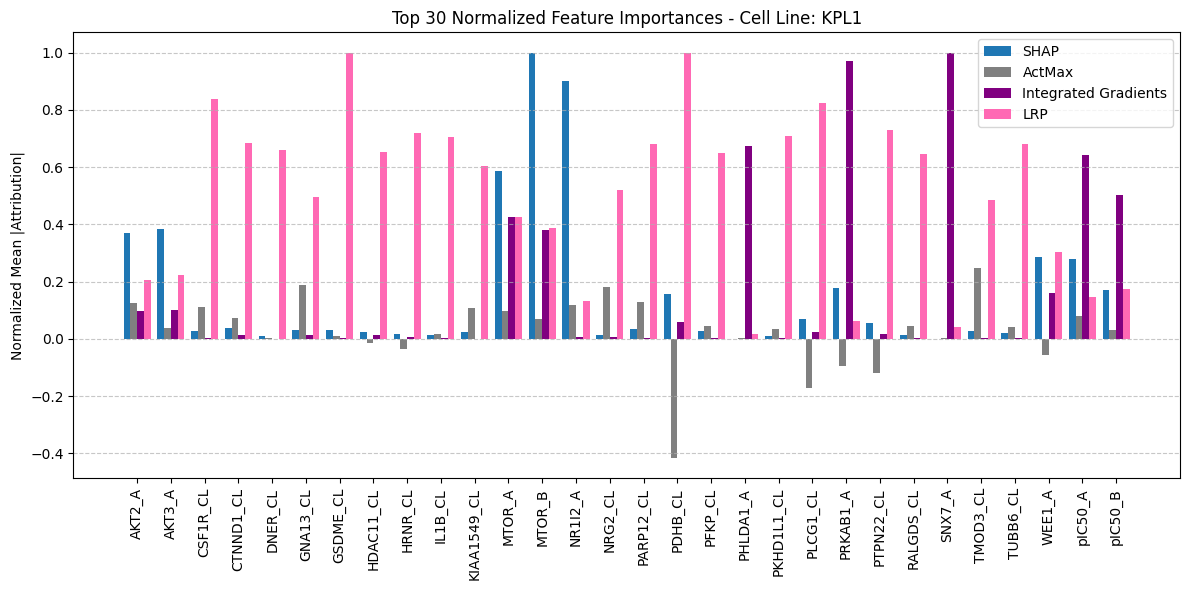

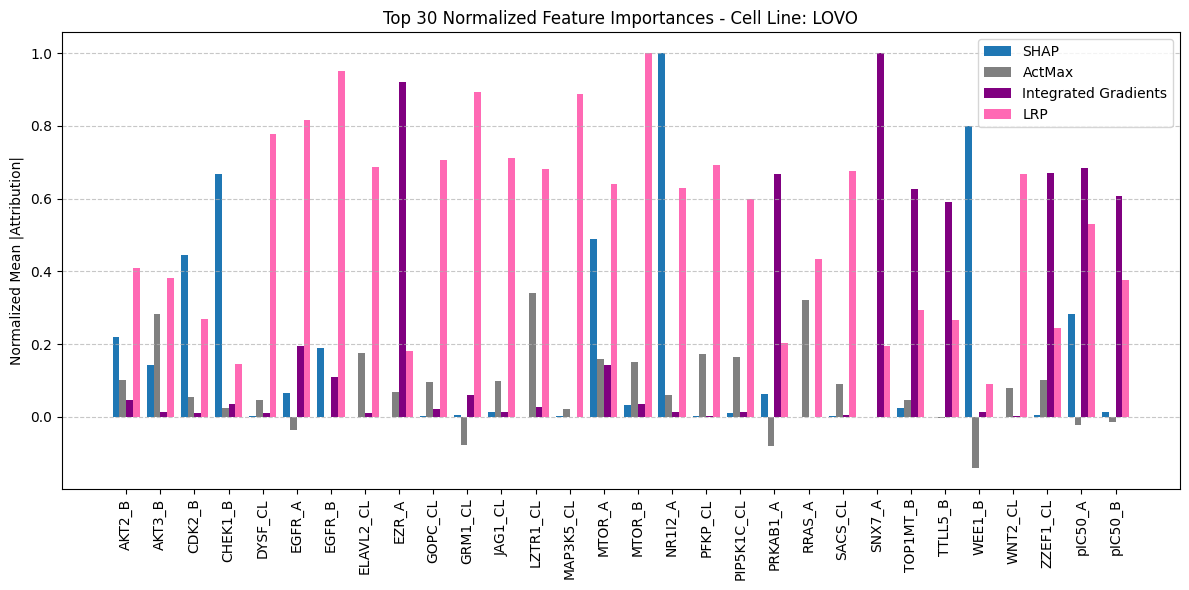

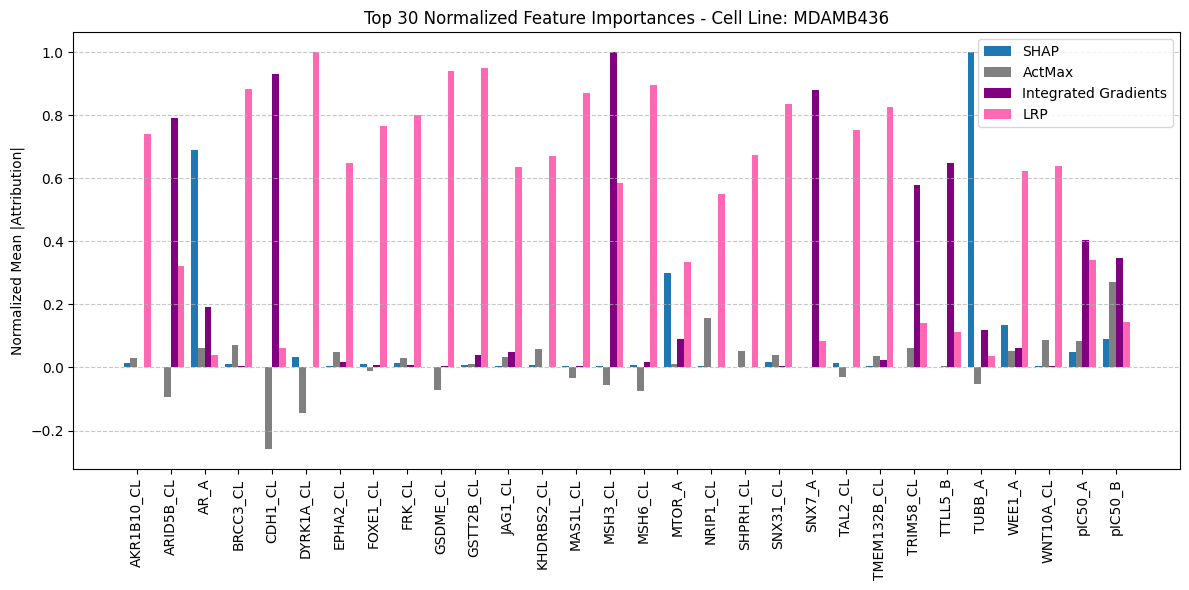

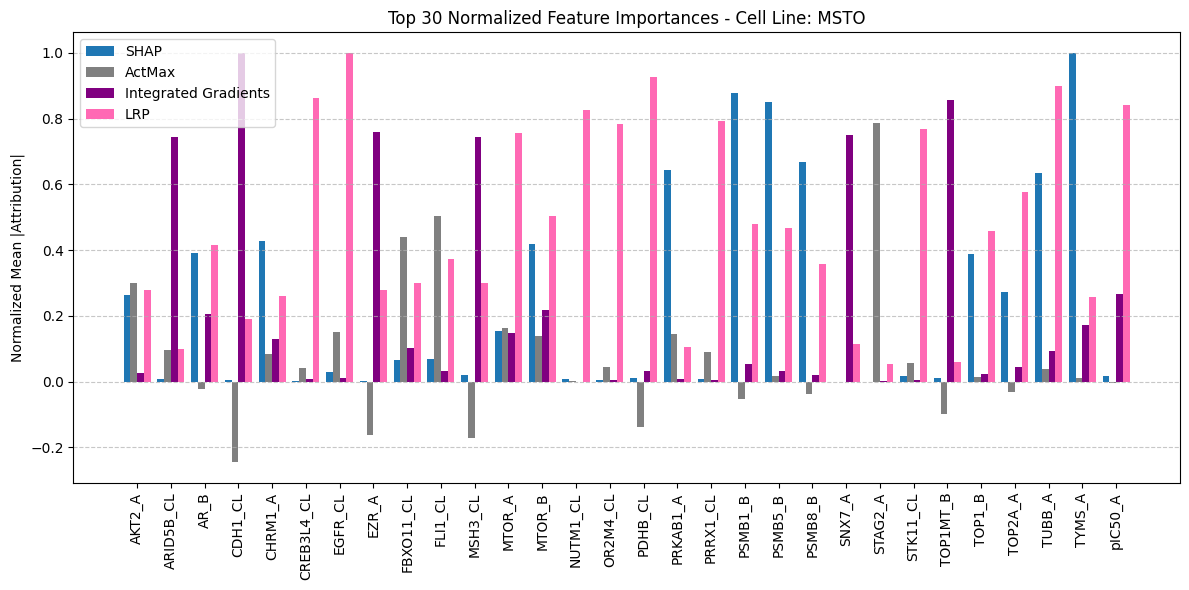

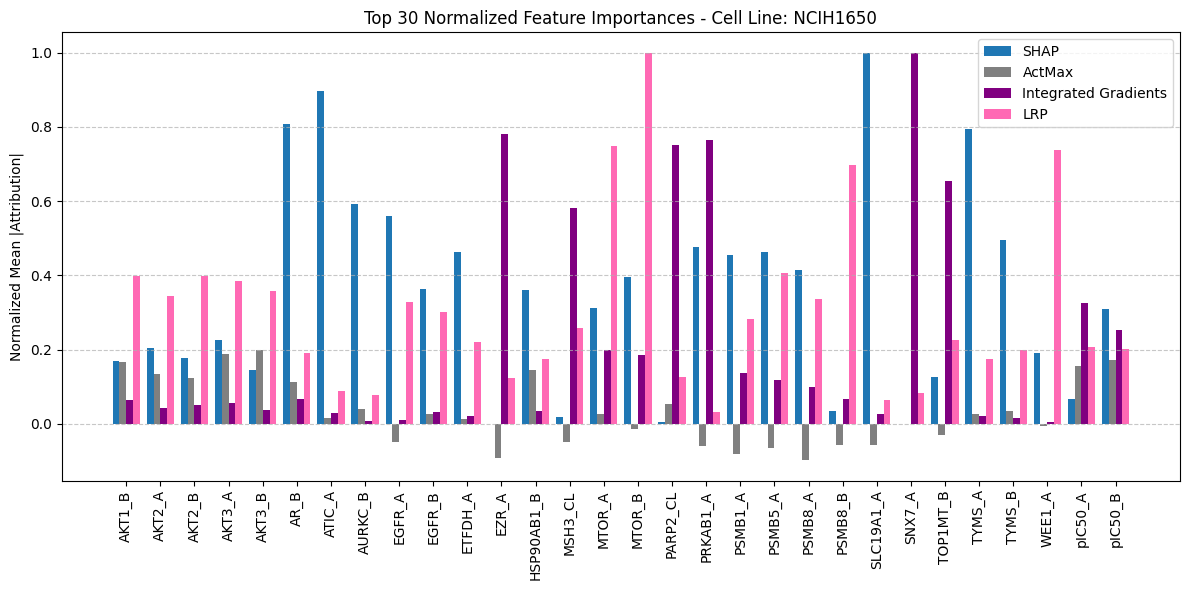

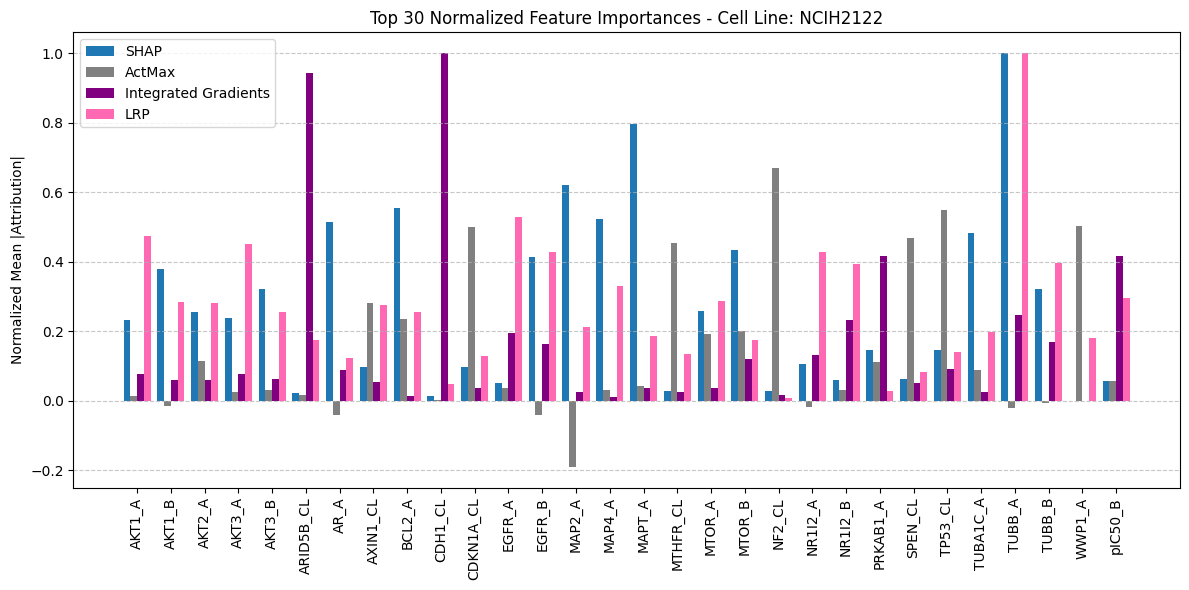

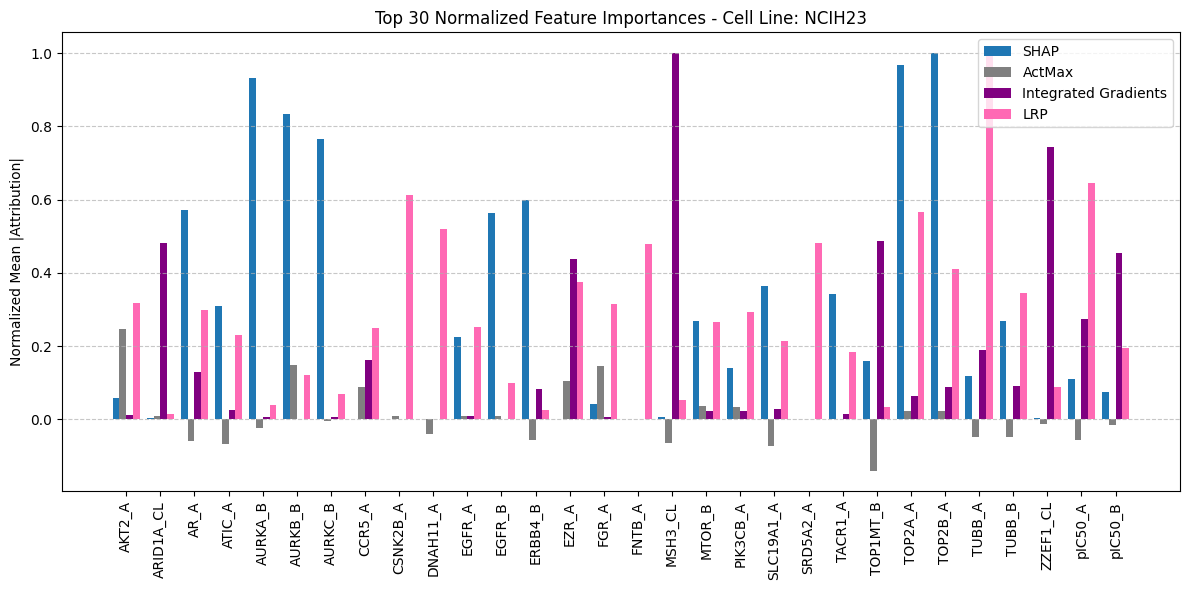

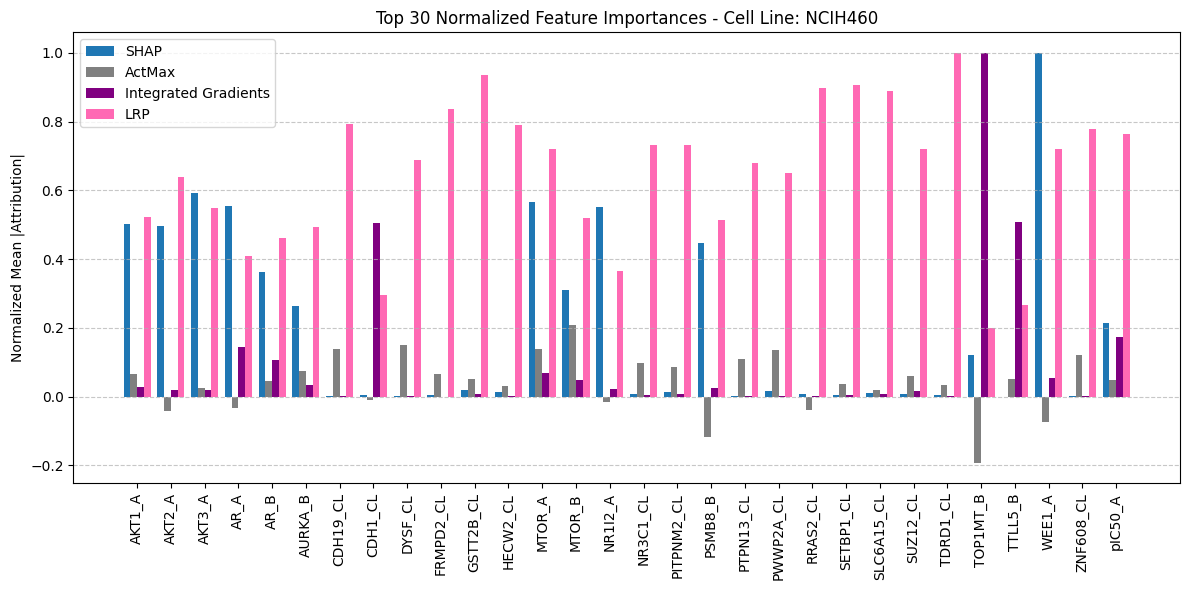

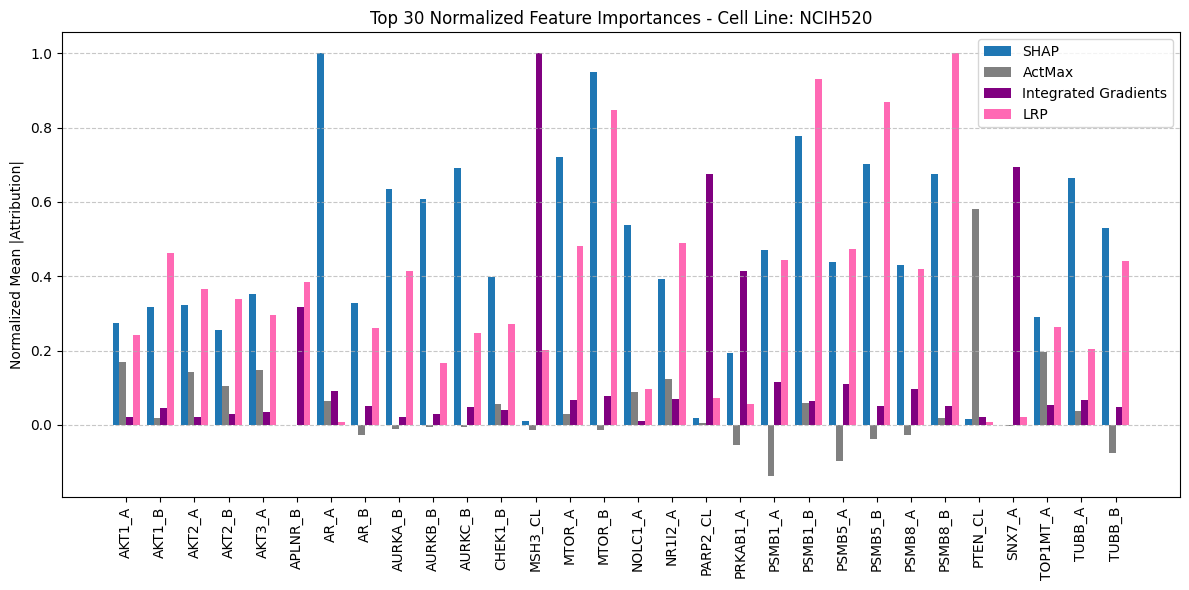

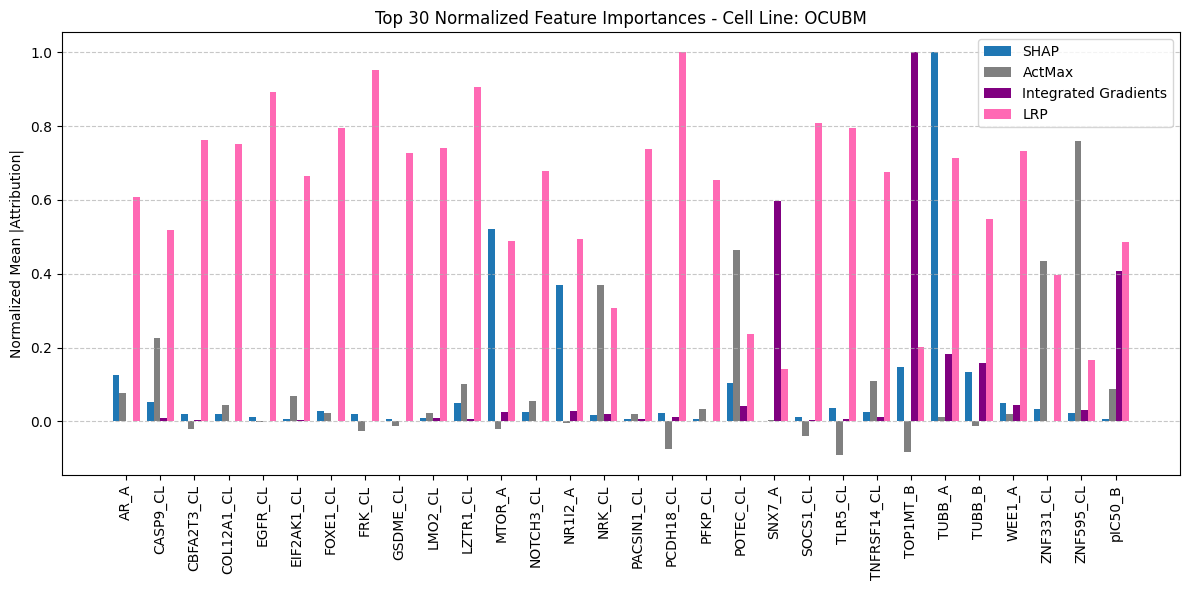

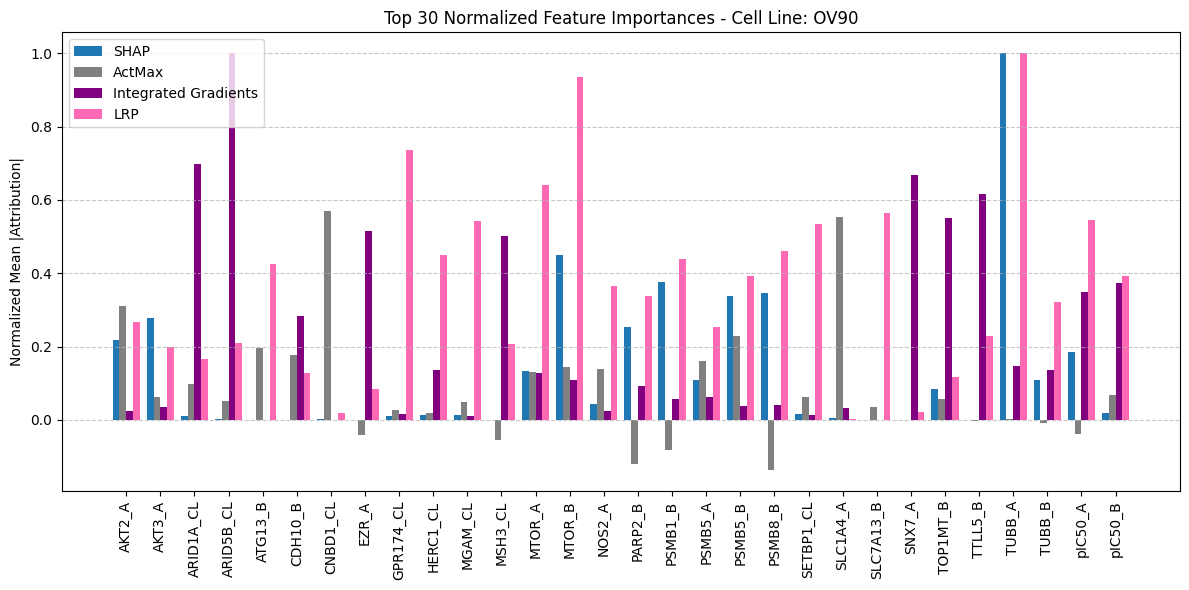

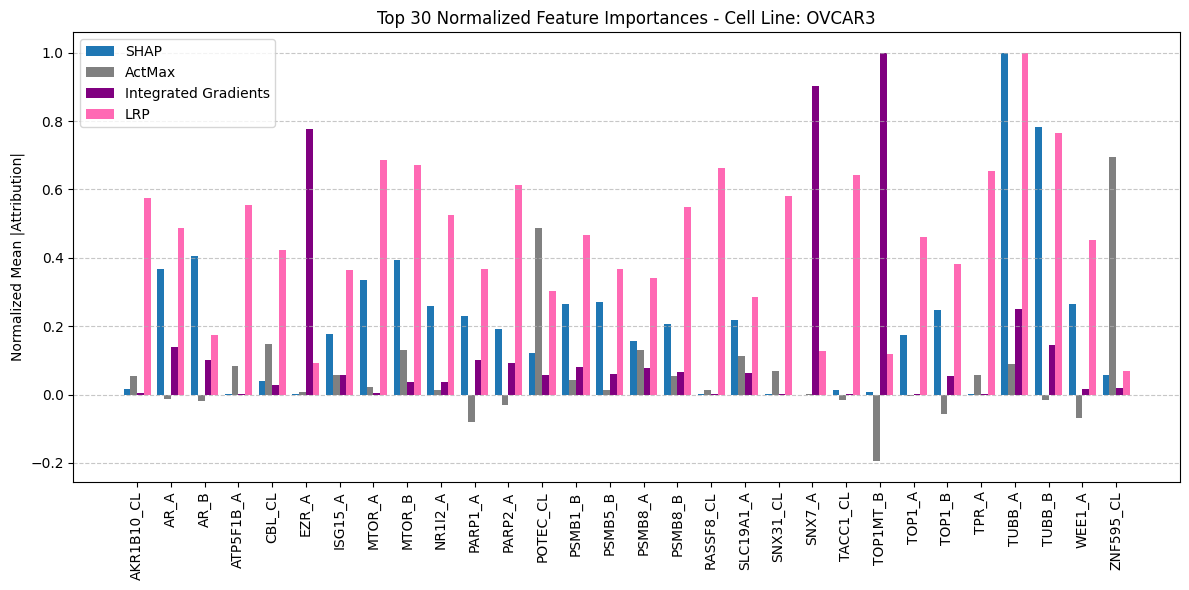

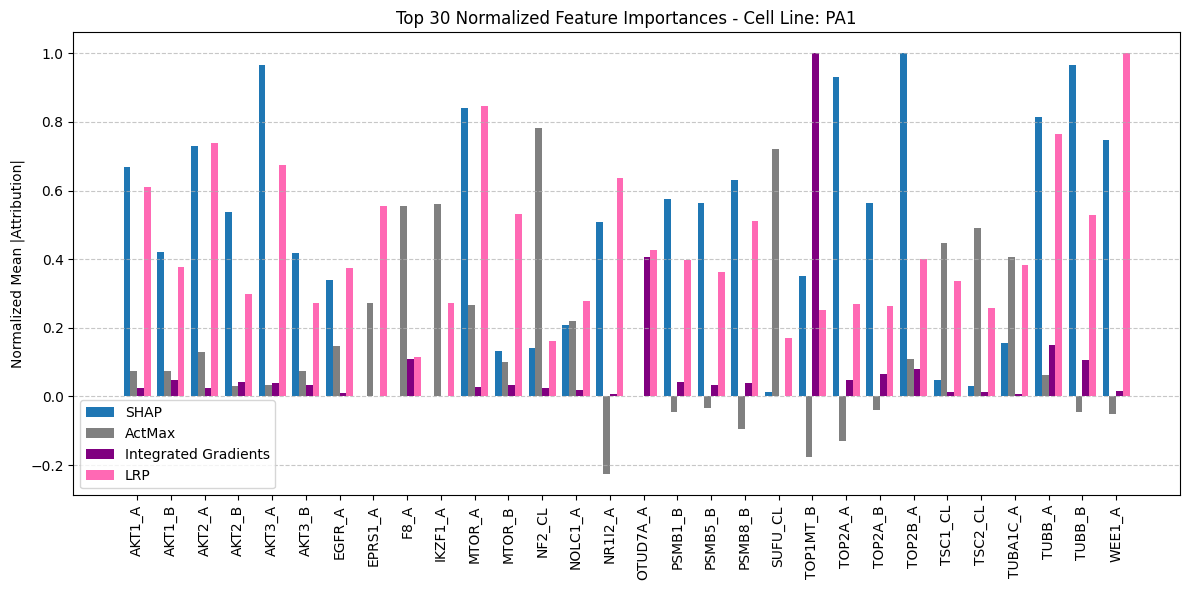

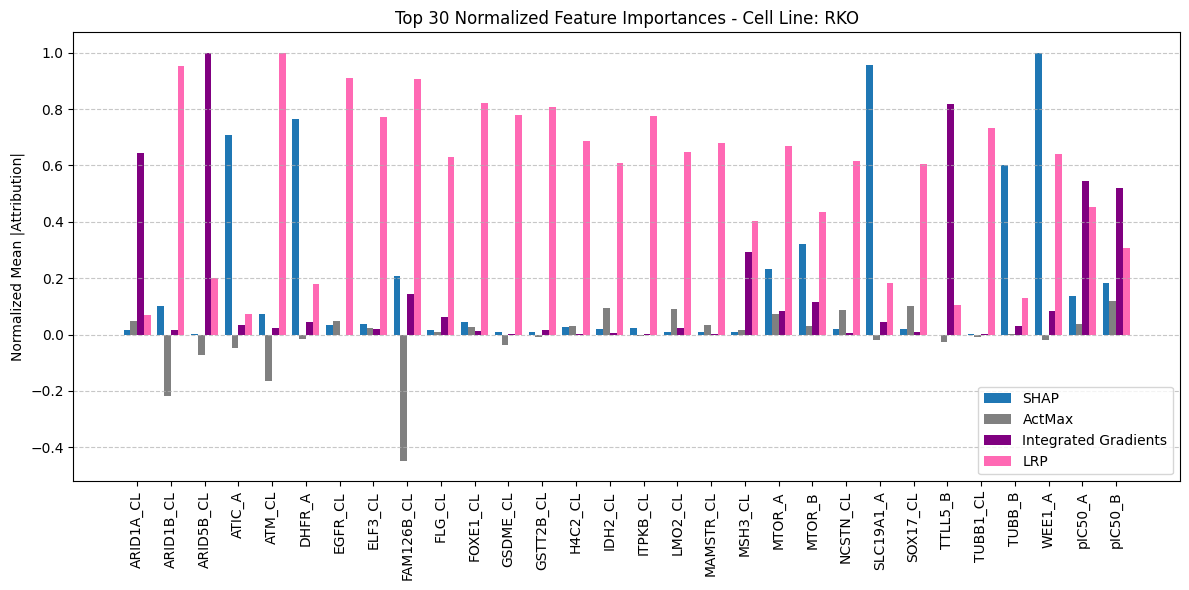

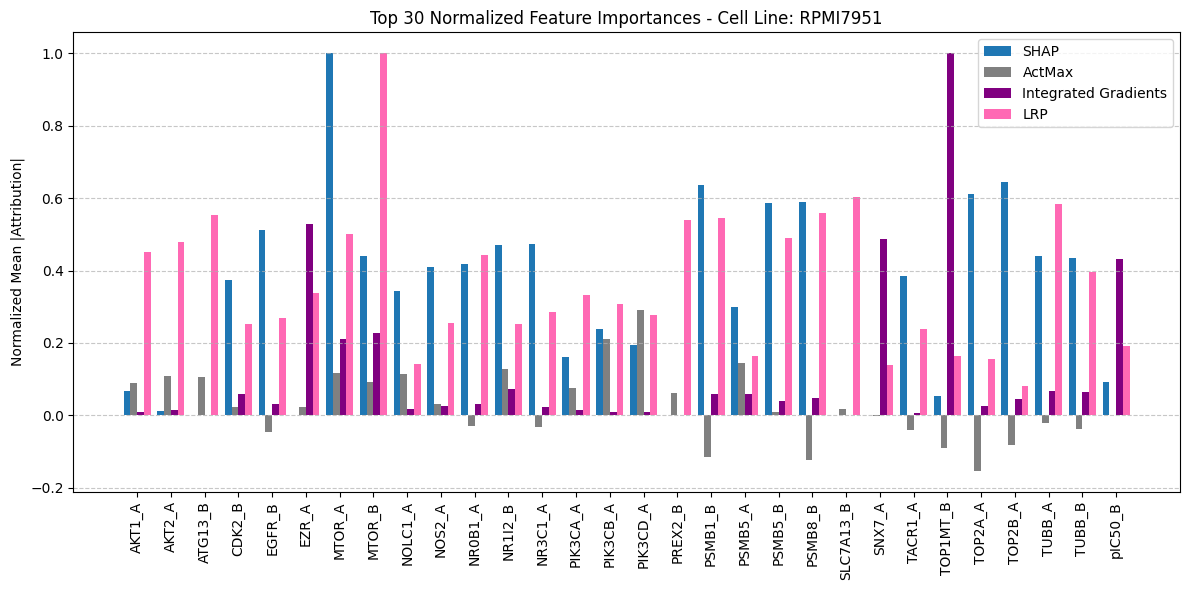

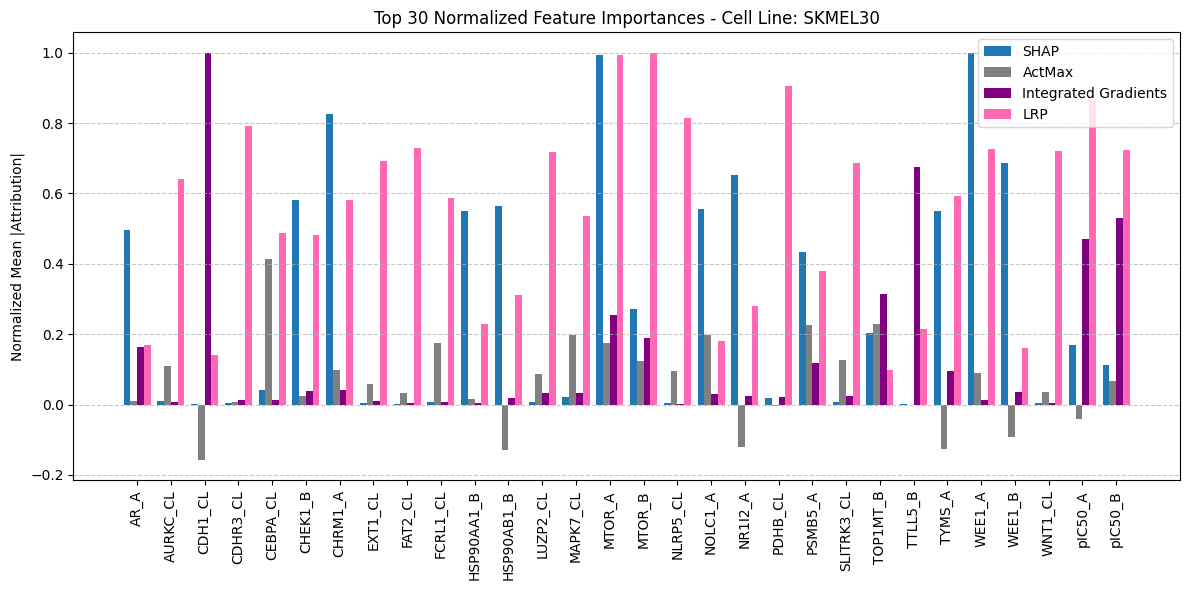

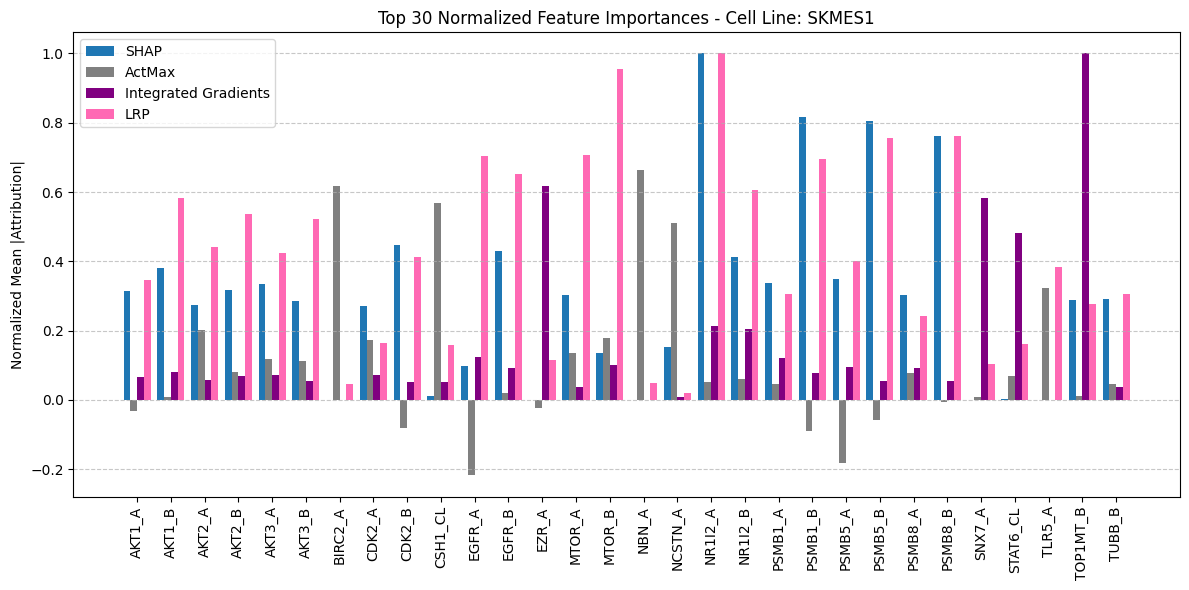

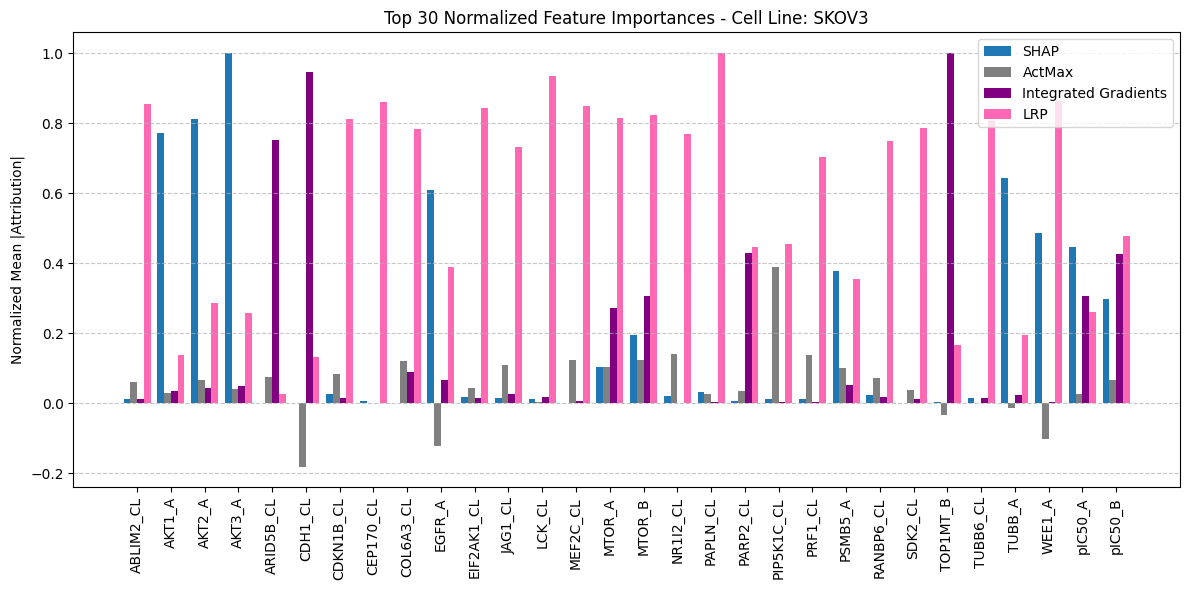

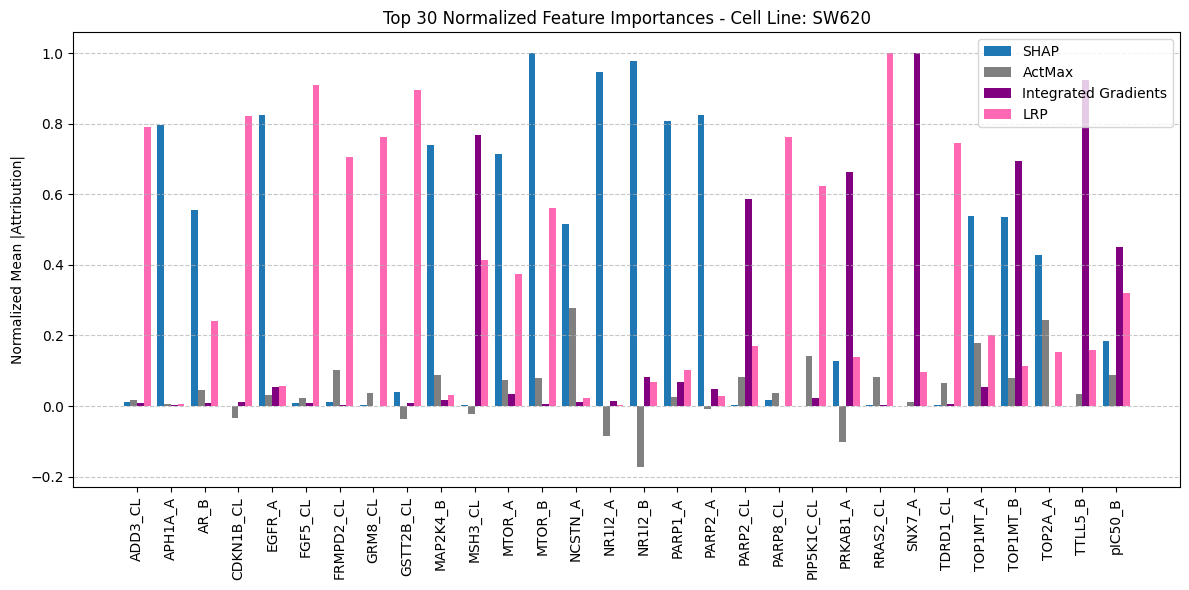

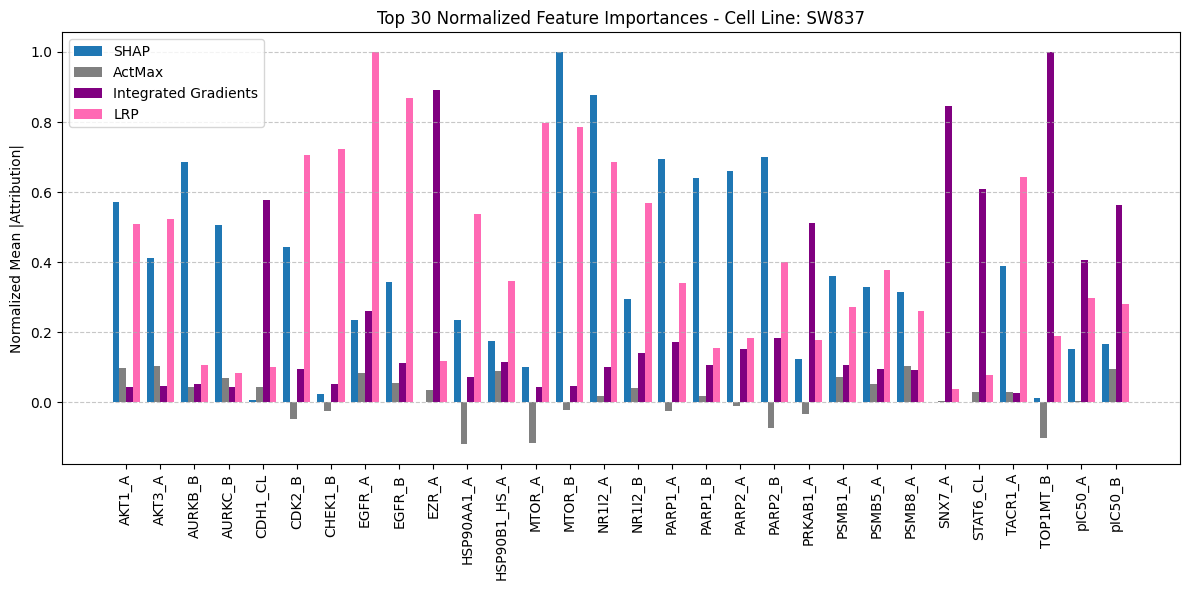

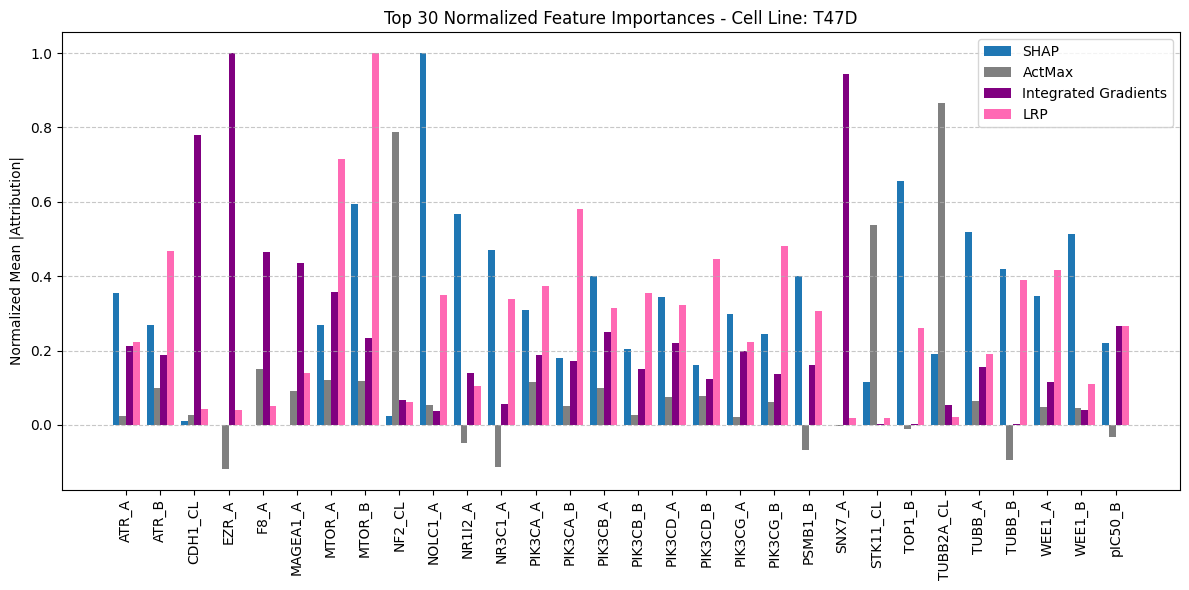

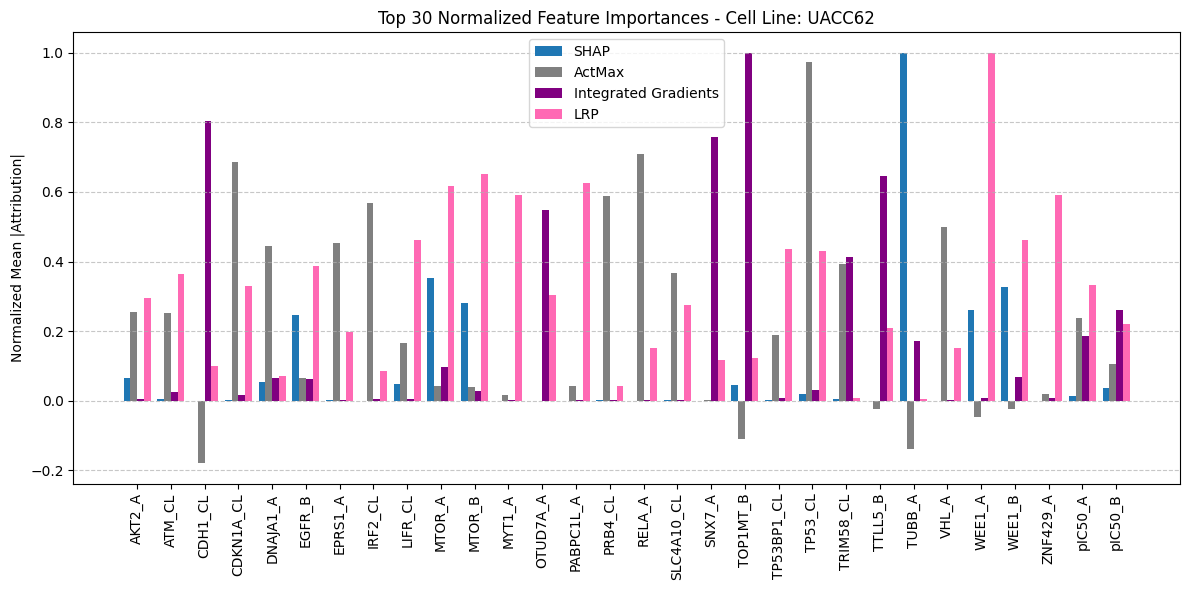

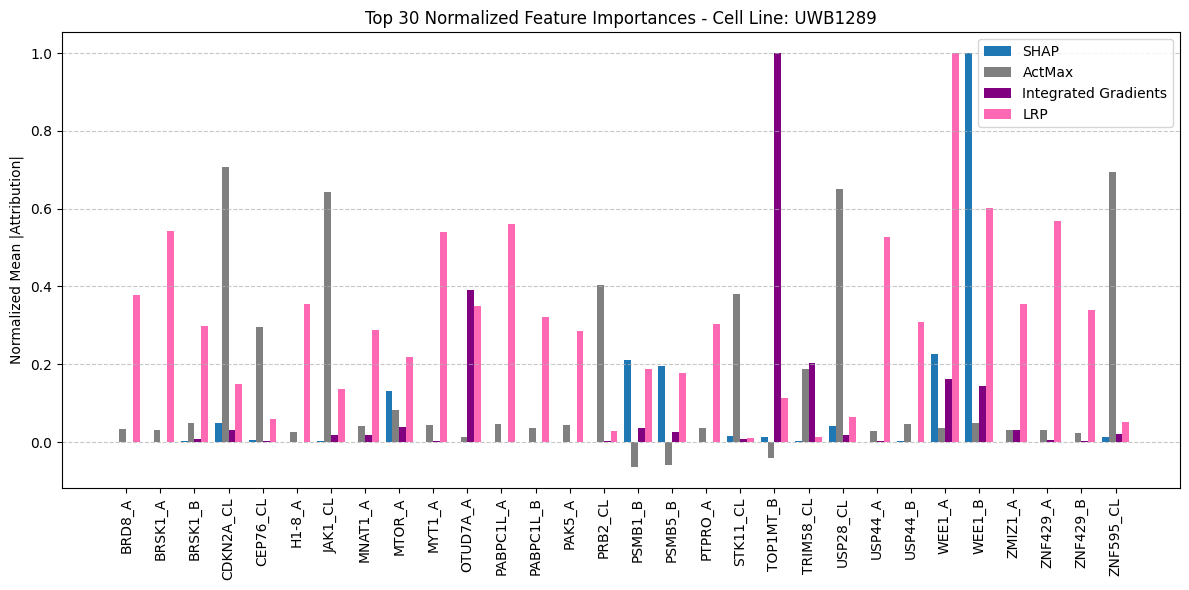

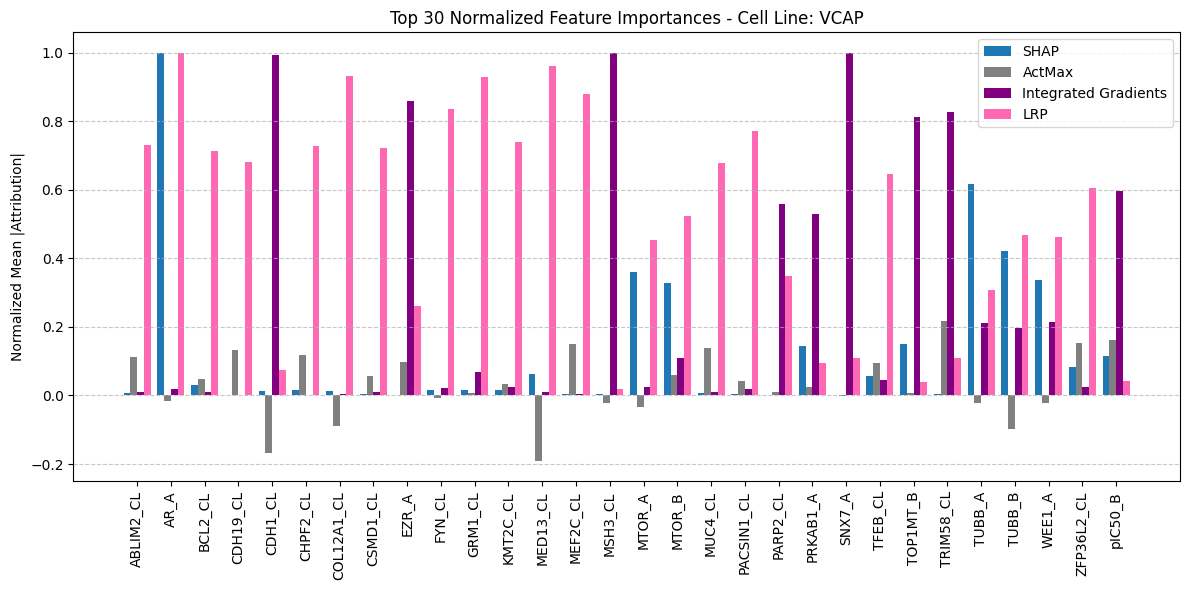

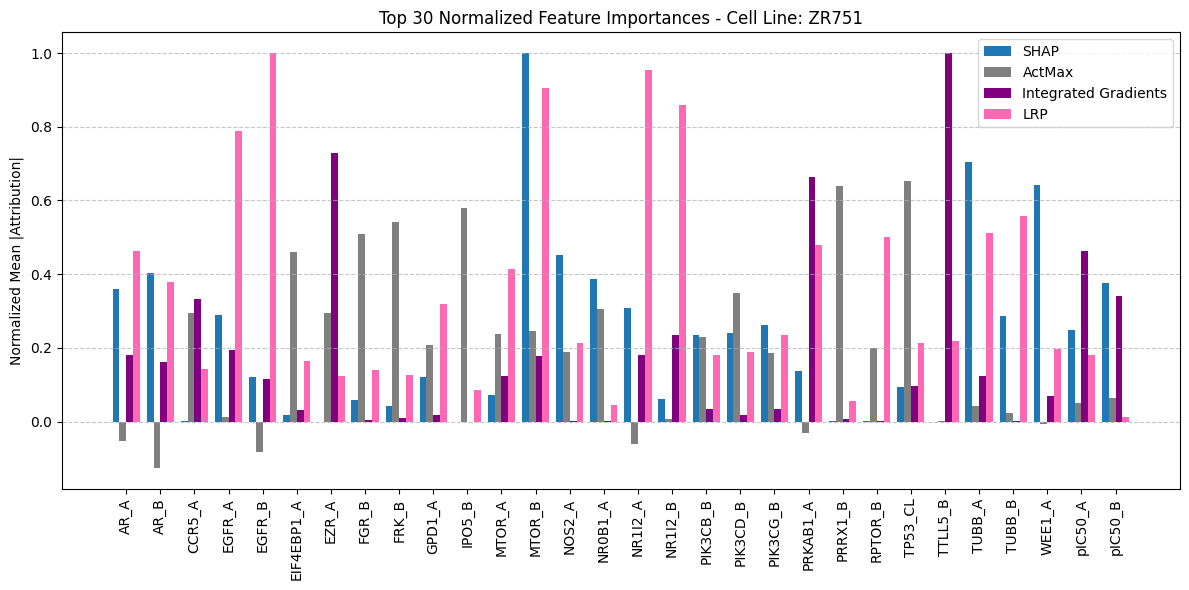

In [5]:
from explainability.data_utils import load_transynergy_cell_line_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def normalize_and_rescale_for_indices(attributions, indices):
    mean_vals = np.mean(attributions[indices], axis=0)  
    mean_abs = np.abs(mean_vals)  
    normed = mean_abs / np.sum(mean_abs)  
    return normed / np.max(normed) 

method_colors = {
        "SHAP": '#1f77b4',
        "ActMax": 'gray',
        "IG": 'purple',
        "LRP": 'hotpink'
    }

def plot_feature_importance_by_cell_line(shap_values, lrp_values, ig_values, shap_indices, feature_names, top_n=30):
    cell_lines_test = load_transynergy_cell_line_data(split='test')
    cell_lines_train = load_transynergy_cell_line_data(split='train')
    cell_lines_train = np.concatenate([cell_lines_train, cell_lines_train], axis=0)

    cell_lines_test = np.array(cell_lines_test)
    cell_lines_train = np.array(cell_lines_train)
    end_od_deduplicated_index = len(cell_lines_train) // 2
    cell_lines_train = cell_lines_train[:end_od_deduplicated_index]

    sampled_cell_lines_shap = cell_lines_test[shap_indices]

    unique_train_cell_lines = np.unique(cell_lines_train)
    
    for cell_line in unique_train_cell_lines:
        shap_idx = np.where(sampled_cell_lines_shap == cell_line)[0]
        lrp_idx = np.where(cell_lines_test == cell_line)[0]
        ig_idx = np.where(cell_lines_train == cell_line)[0]

        shap_imp = normalize_and_rescale_for_indices(shap_values, shap_idx)
        lrp_imp = normalize_and_rescale_for_indices(lrp_values, lrp_idx)
        ig_imp = normalize_and_rescale_for_indices(ig_values, ig_idx)

        am_cell_line = load_am_results_by_cell_line(paper ="transynergy", cell_line=cell_line, regularization="l2_input")
        am_norm = am_cell_line / np.sum(np.abs(am_cell_line))
        am_norm = am_norm / np.max(np.abs(am_norm))
        
        df = pd.DataFrame({
            "feature": feature_names,
            "SHAP": shap_imp,
            "LRP": lrp_imp,
            "IG": ig_imp,
            "ActMax": am_norm
        })

        df["avg"] = df[["SHAP", "ActMax", "IG", "LRP"]].mean(axis=1)
        top_features = df.sort_values("avg", ascending=False).head(top_n)
        top_features = top_features.sort_values("feature")  

        x = np.arange(top_n)
        width = 0.2

        plt.figure(figsize=(12, 6))
        plt.bar(x - 1.5*width, top_features["SHAP"], width, label="SHAP", color=method_colors["SHAP"])
        plt.bar(x - 0.5*width, top_features["ActMax"], width, label="ActMax", color=method_colors["ActMax"])
        plt.bar(x + 0.5*width, top_features["IG"], width, label="Integrated Gradients", color=method_colors["IG"])
        plt.bar(x + 1.5*width, top_features["LRP"], width, label="LRP", color=method_colors["LRP"])

        plt.xticks(x, top_features["feature"], rotation=90)
        plt.ylabel("Normalized Mean |Attribution|")
        plt.title(f"Top {top_n} Normalized Feature Importances - Cell Line: {cell_line}")
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_feature_importance_by_cell_line(
    shap_values=shap_values,
    lrp_values=lrp_values,
    ig_values=ig_values,
    shap_indices=shap_indices,
    feature_names=feature_names
)



In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
from explainability.data_utils import load_transynergy_cell_line_data

def top_k_jaccard(a, b, k=10):
    top_a = set(np.argsort(np.abs(a))[-k:])
    top_b = set(np.argsort(np.abs(b))[-k:])
    return len(top_a & top_b) / k

def compute_similarity_metrics_per_cell_line(shap_values, lrp_values, ig_values, feature_names, k=10):
    cell_lines_train = load_transynergy_cell_line_data(split='train'),
    cell_lines_test = load_transynergy_cell_line_data(split='test')
    cell_lines_test = np.array(cell_lines_test)
    cell_lines_train = np.array(cell_lines_train)
    
    sampled_cell_lines_shap = cell_lines_test[shap_indices]

    unique_train_cell_lines = np.unique(cell_lines_train)
    
    results = []

    for cell_line in unique_train_cell_lines:
        shap_idx = np.where(sampled_cell_lines_shap == cell_line)[0]
        lrp_idx = np.where(cell_lines_test == cell_line)[0]
        ig_idx = np.where(cell_lines_train == cell_line)[0]
        
        am_cell_line = load_am_results_by_cell_line(paper="transynergy", cell_line=cell_line, regularization="l2_input")
        
        shap_mean = np.mean(shap_values[shap_idx], axis=0)
        lrp_mean = np.mean(lrp_values[lrp_idx], axis=0)
        ig_mean = np.mean(ig_values[ig_idx], axis=0)
        

        # Spearman correlation
        s_ig_corr, _ = spearmanr(shap_mean, ig_mean)
        s_lrp_corr, _ = spearmanr(shap_mean, lrp_mean)
        ig_lrp_corr, _ = spearmanr(ig_mean, lrp_mean)
        s_am_corr, _ = spearmanr(shap_mean, am_cell_line)
        lrp_am_corr, _ = spearmanr(lrp_mean, am_cell_line)
        ig_am_corr, _ = spearmanr(ig_mean, am_cell_line)

        # Cosine similarity
        cos_s_ig = cosine_similarity([shap_mean], [ig_mean])[0][0]
        cos_s_lrp = cosine_similarity([shap_mean], [lrp_mean])[0][0]
        cos_ig_lrp = cosine_similarity([ig_mean], [lrp_mean])[0][0]
        cos_s_am = cosine_similarity([shap_mean], [am_cell_line])[0][0]
        cos_lrp_am = cosine_similarity([lrp_mean], [am_cell_line])[0][0]
        cos_ig_am = cosine_similarity([ig_mean], [am_cell_line])[0][0]
        
        # Top-k Jaccard overlap
        jac_s_ig = top_k_jaccard(shap_mean, ig_mean, k)
        jac_s_lrp = top_k_jaccard(shap_mean, lrp_mean, k)
        jac_ig_lrp = top_k_jaccard(ig_mean, lrp_mean, k)
        jac_s_am = top_k_jaccard(shap_mean, am_cell_line, k)
        jac_lrp_am = top_k_jaccard(lrp_mean, am_cell_line,
    k)
        jac_ig_am = top_k_jaccard(ig_mean, am_cell_line, k)

        results.append({
            "cell_line": cell_line,
            "spearman_shap_ig": s_ig_corr,
            "spearman_shap_lrp": s_lrp_corr,
            "spearman_ig_lrp": ig_lrp_corr,
            "cosine_shap_ig": cos_s_ig,
            "cosine_shap_lrp": cos_s_lrp,
            "cosine_ig_lrp": cos_ig_lrp,
            "jaccard_shap_ig": jac_s_ig,
            "jaccard_shap_lrp": jac_s_lrp,
            "jaccard_ig_lrp": jac_ig_lrp,
            "spearman_shap_am": s_am_corr,
            "spearman_lrp_am": lrp_am_corr,
            "spearman_ig_am": ig_am_corr,
            "cosine_shap_am": cos_s_am,
            "cosine_lrp_am": cos_lrp_am,
            "cosine_ig_am": cos_ig_am,
            "jaccard_shap_am": jac_s_am,
            "jaccard_lrp_am": jac_lrp_am,
            "jaccard_ig_am": jac_ig_am,
            
        })

    return pd.DataFrame(results)

similarity_df = compute_similarity_metrics_per_cell_line(
    shap_values, lrp_values, ig_values, feature_names, k=10
)
print(similarity_df.head())


[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
[fold] Leakage:
  • Test ↔ Train: 0
  • Val  ↔ Train: 0
  • Val  ↔ Test : 0
Original rows: 18552
Remaining rows after cleaning: 18552
  cell_line  spearman_shap_ig  spearman_shap_lrp  spearman_ig_lrp  \
0     A2058          0.096444           0.055851        -0.047453   
1     A2780          0.070824           0.204160        -0.035794   
2      A375          0.058374           0.019754        -0.037819   
3      A427          0.029554           0.038885        -0.015398   
4     CAOV3          0.072994          -0.068535        -0.041909   

   cosine_shap_ig  cosine_shap_lrp  cosine_ig_lrp  jaccard_shap_ig  \
0        0.046666        -0.013477      -0.010215              0.0   
1        0.055212        -0.004643      -0.004309              0.0   
2       -0.010227        -0.043851       0.021740              0.0   
3        0.027789        -0.029184   

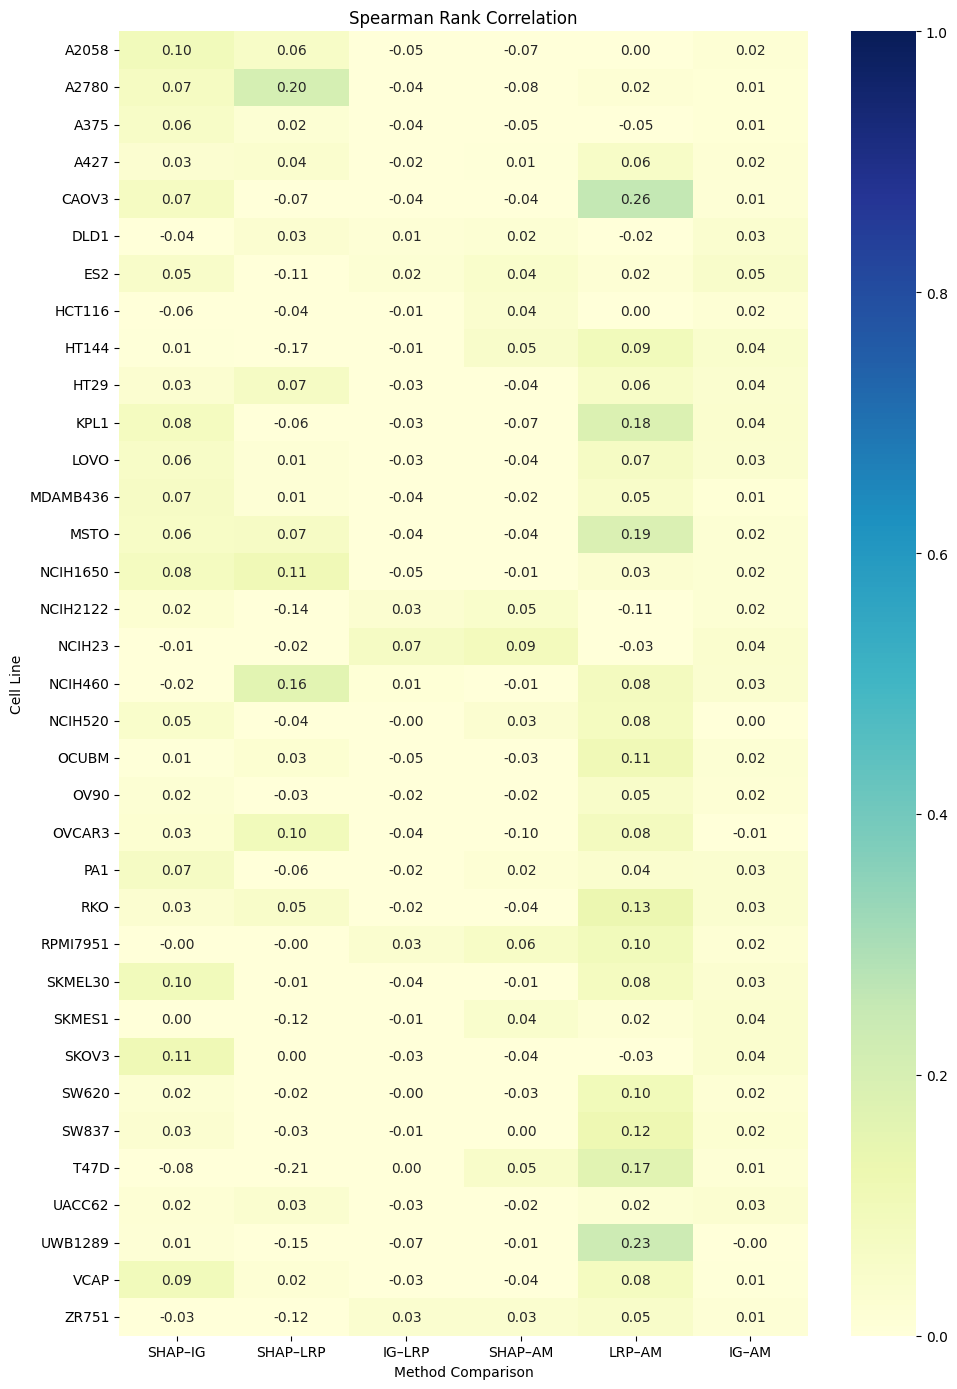

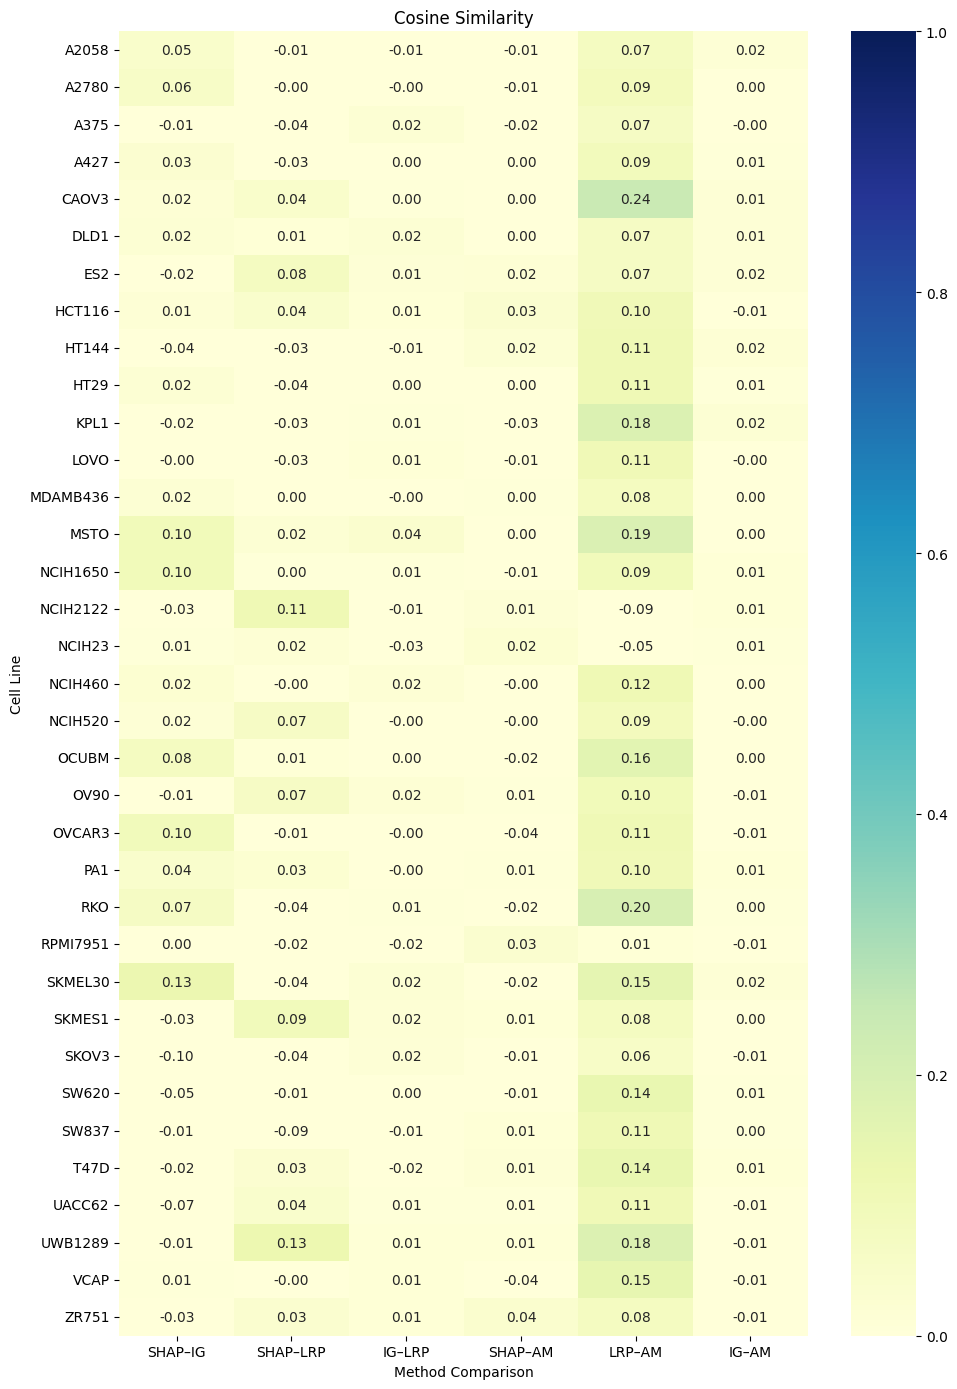

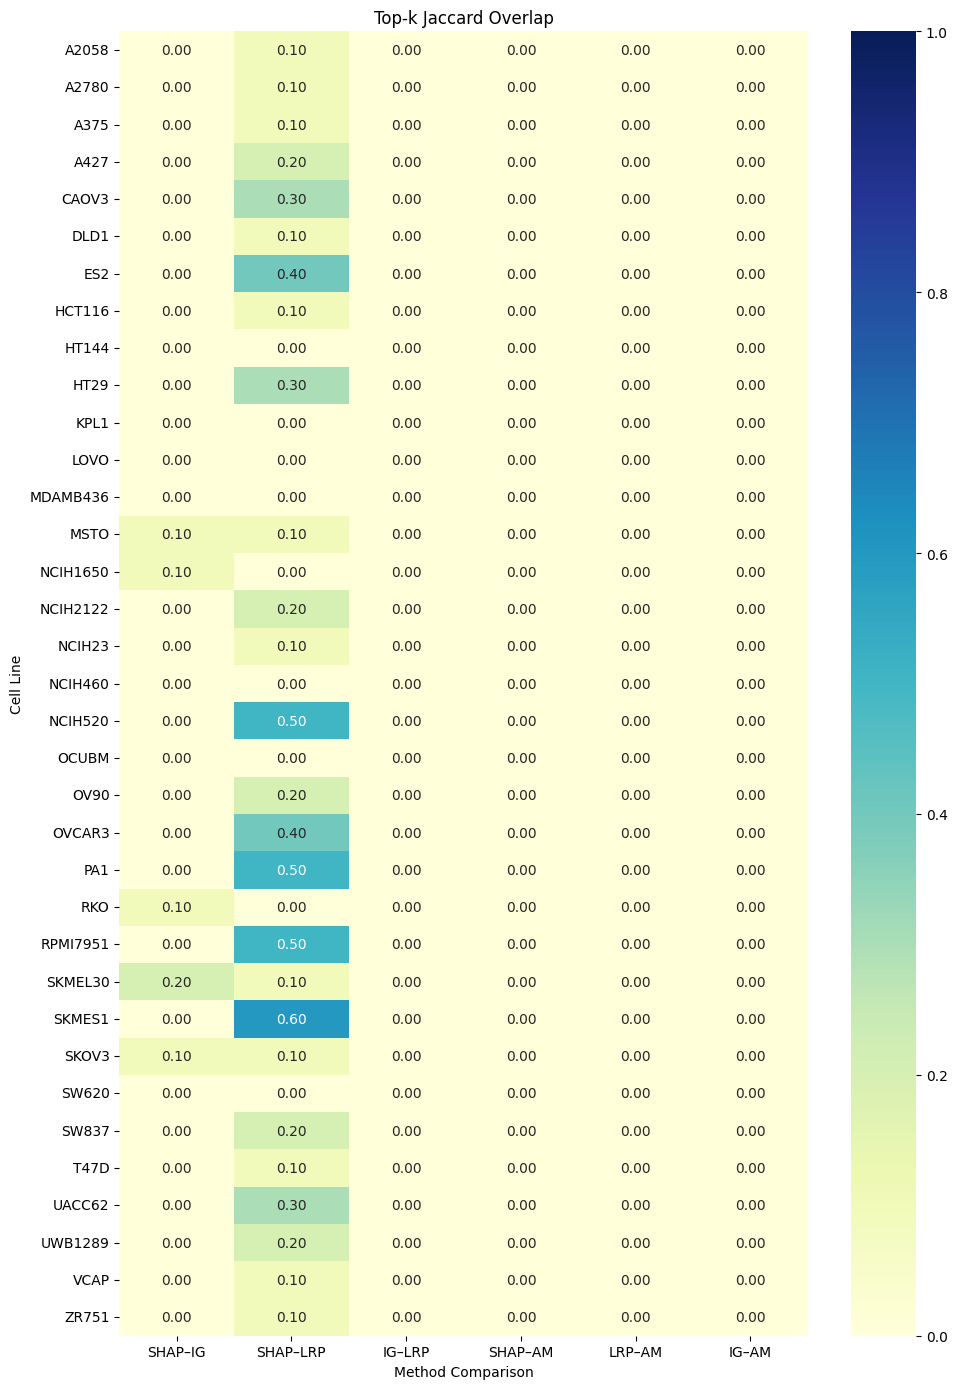

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity_heatmaps(similarity_df):
    cell_lines = similarity_df["cell_line"]
    metric_map = {
        "Spearman Rank Correlation": ["spearman_shap_ig", "spearman_shap_lrp", "spearman_ig_lrp", "spearman_shap_am", "spearman_lrp_am", "spearman_ig_am"],
        "Cosine Similarity": ["cosine_shap_ig", "cosine_shap_lrp", "cosine_ig_lrp", "cosine_shap_am", "cosine_lrp_am", "cosine_ig_am"],
        "Top-k Jaccard Overlap": ["jaccard_shap_ig", "jaccard_shap_lrp", "jaccard_ig_lrp", "jaccard_shap_am", "jaccard_lrp_am", "jaccard_ig_am"],
    }

    for title, cols in metric_map.items():
        data = similarity_df[cols]
        data.index = cell_lines
        data.columns = ["SHAP–IG", "SHAP–LRP", "IG–LRP", "SHAP–AM", "LRP–AM", "IG–AM"]
        plt.figure(figsize=(10, max(6, 0.4 * len(cell_lines))))
        sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=1, cbar=True)
        plt.title(title)
        plt.xlabel("Method Comparison")
        plt.ylabel("Cell Line")
        plt.tight_layout()
        plt.show()

plot_similarity_heatmaps(similarity_df)



If we focus on Spearman Rank Correlation (most trustworthy comparison method for this case), we can observe that unfortunately there is a small correlation between explainability methods. The two most similar being AM and LRP, and SHAP and LRP. This is probably also due to the fact that there are a lot of (relevant) features to choose and focus on, even more than in Biomining.